# P53 - DMS Analyse
#### by Frido Petersen, Dario Prifti, Maximilian Fidlin and Enno Schäfer
*With special thanks to our Co-Worker, inspiration and beloved friend: Chat-GPT*

In [ ]:
%load_ext autoreload
%autoreload 2
#
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import data_exploration as de
import data_cleanup as dc
import functions as fun
import Documentation as doc
import severity_score as ses
import matplotlib.pyplot as plt

In [ ]:
# These are all the datasets we used
gia_null_eto: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_NULL_Etoposide_2018.csv')
gia_null_nut: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_NULL_Nutlin_2018.csv')
gia_wt_nut: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Giacomelli_WT_Nutlin_2018.csv')
kot_hum: pd.DataFrame = pd.read_csv('../DMS_data/P53_HUMAN_Kotler_2018.csv')

aa = pd.read_csv('../DMS_data/aminoacids.csv')

## Comparibility of p53 Datasets
#### Finding similarities and differences in the 4 datasets on p53

In [ ]:
# Giacomelli Null Etoposide, Giacomelli Wildtype Nutlin, Giacomelli Null Nutlin
fun.mult_hmap(gia_null_eto_norm, gia_wt_nut_norm, gia_null_nut_norm)

In [ ]:
# Kotler
fun.hmap(doc.kot_hum_auf)

In [ ]:
fun.calculate_average_dms_score_old(('GNE', doc.gia_null_eto_amp_norm), ('GNN', doc.gia_null_nut_amp_norm), ('GWN', doc.gia_wt_nut_amp_norm), ('KH', doc.kot_hum_amp_norm))

In [ ]:
fun.calculate_average_dms_score_new(('GNE', doc.gia_null_eto_amp), ('GNN', doc.gia_null_nut_amp), ('GWN', doc.gia_wt_nut_amp), ('KH', doc.kot_hum_amp))

In [ ]:
fun.hmap_mean_variance(doc.mean_substitutionsGNE)
fun.hmap_mean_variance(doc.mean_substitutionsGNN)
fun.hmap_mean_variance(doc.mean_substitutionsGWN)
fun.hmap_mean_variance(doc.mean_substitutionsKH)

In [ ]:
# These heatmaps show different trends:
# What we need to consider is that the Kotler dataset only covers a range of amino acids. From postion 102 to 292.                                      While the "Giacomelli Wildtype Nutlin" and "Giacomelli Null Nutlin" datasets exhibit some similarities in terms of trends and values, the same cannot be said when comparing them to the "Giacomelli Null Etoposide" dataset. This disparity is likely due to the use of different p53 activating agents, namely nutlin-3 and etoposide. One notable observation across all datasets is that amino acids in the range of approximately 100-300 generally display a negative effect caused by mutations. This could indicate a specific region that is evolutionary conserved and perfected. Additionally, the Kotler dataset exhibits a scarcity of values, which should be taken into consideration for future work.
# In addition to visually comparing the datasets, I wanted to investigate whether the datasets share positions in the amino acid sequence where the sum of all DMS scores is the lowest. This would indicate that these specific locations are particularly conserved.

In [ ]:
# The 5 lowest values in the "Giacomelli null etoposide" dataset
doc.GNELV

In [ ]:
# The 5 highest values in the "Giacomelli null etoposide" dataset
doc.GNEHV

In [ ]:
# The positions (-> most affected by mutation) are the following throughout each Dataset:
doc.lowest_vals.head(20)

In [ ]:
doc.liniengraph(dataframes=[doc.gia_null_eto_z_mmn_df_mean, doc.gia_null_nut_z_mmn_df_mean, doc.gia_wt_nut_z_mmn_df_mean, doc.kot_hum_z_mmn_df_mean])

## Data cleanup
#### Preparing the data to enable further anaylses

In [ ]:
# min max Normalisierung
norm_frame = dc.aufteilung_mut_pos(dc.norm(gia_null_eto))
print("Z-transfromation and Min Max normalisation of df")
fun.hmap(norm_frame)
print(f"Position of Low and High values of frame")
dc.min_max_val(norm_frame)

After we finished cleaning our data, we decided to transform the data into a new, more compact format.
In this new data frame the rows resemble the original AA sequence and the rows represent the exchange with a specific AA (e.g. A). The shown values are the DMS scores for the shown substitution. The NAs   shown for the exchanges where the old and new AA are the same, are changed to the value zero. With this transformed data set, further analyses are more easily to perform.

Max: Wir haben probiert Patientendaten zu bekommen, aber wir haben die nicht bekommen

## Data exploration
#### First, we calculated the distance and mean substitution matrices. With these DataFrames, we performed PCA, clustering and plotted the results. To understand the code and see additional plots, take a look at the "data_exploration" python package.

In [ ]:
# calculate feature matrices
feature_matrix_aa = dc.clean_aa(aa)
feature_matrix_p53 = dc.rmv_na(dc.df_transform(norm_frame))

In [ ]:
# calculate distance matrices as well as mean substitution matrices
dist_chem = de.aa_distance_matrix(aa)

dist_wt_p53 = de.dms_distance_matrix_wt(norm_frame)
dist_mut_p53 = de.dms_distance_matrix_mutated(norm_frame)

mean_subs_wt_p53 = dc.rmv_na(de.mean_substitutions(norm_frame))
mean_subs_mut_p53 = dc.rmv_na(de.mean_substitutions(norm_frame).T)

In [ ]:
# hierarchical ward clustering
de.plot_hier_clust(dist_chem, title = "AAs chemical properties")
print("---------------------------------")
de.plot_hier_clust(dist_wt_p53, title = "p53 distance matrix of WT AAs")
de.plot_hier_clust(dist_mut_p53, title = "p53 distance matrix of mutated AAs")
print("---------------------------------")
de.plot_hier_clust(mean_subs_wt_p53, title = "p53 mean substitutions for WT AAs")
de.plot_hier_clust(mean_subs_mut_p53, title = "p53 mean substitutions for mutated AAs")

In [ ]:
# determine optimal amount of clusters
clusters_by_sil_chem = de.determine_clusters_silhouette(feature_matrix_aa)

clusters_by_sil_p53 = de.determine_clusters_silhouette(feature_matrix_p53)


print (clusters_by_sil_chem)
print ("---")
print (clusters_by_sil_p53)

Explained variance for PCA of AAs clustered by chemical properties:
PC1: 0.36
PC2: 0.23


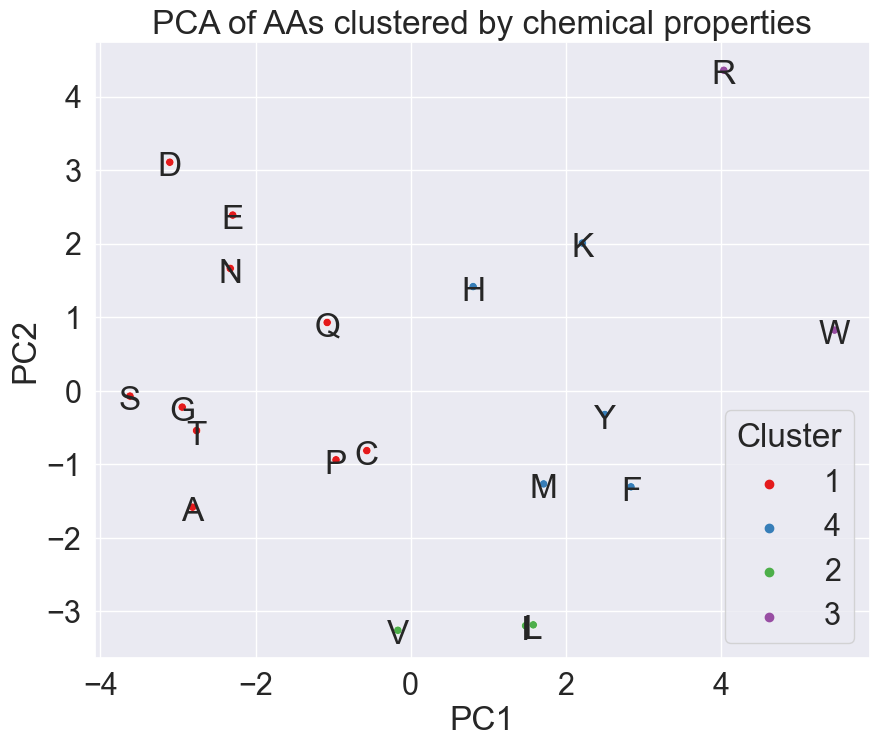

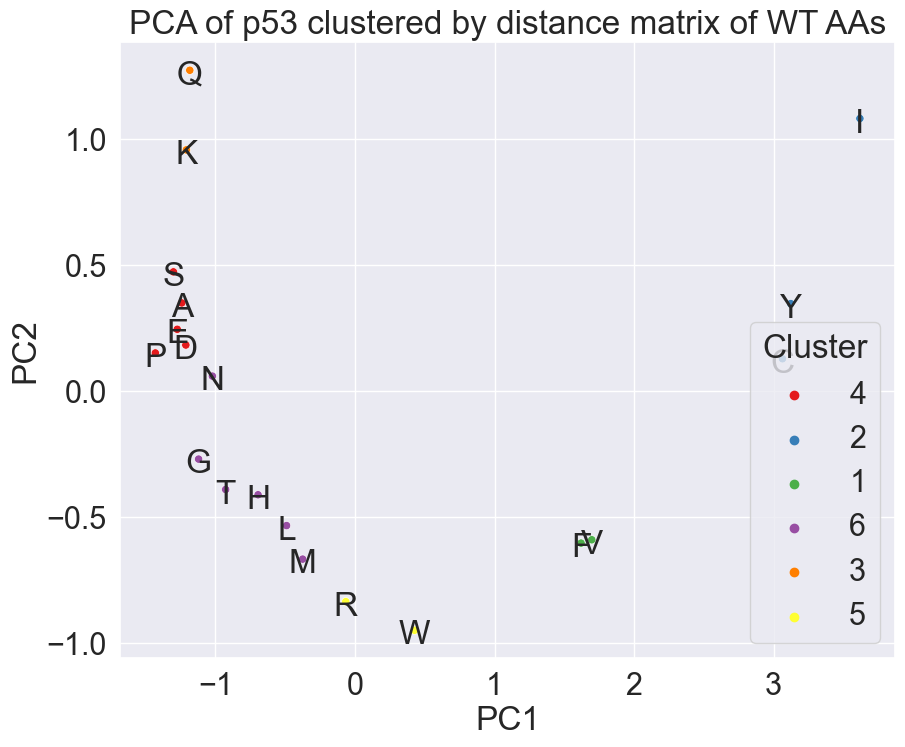

Explained variance for PCA of p53 clustered by distance matrix of mutated AAs:
PC1: 0.43
PC2: 0.16


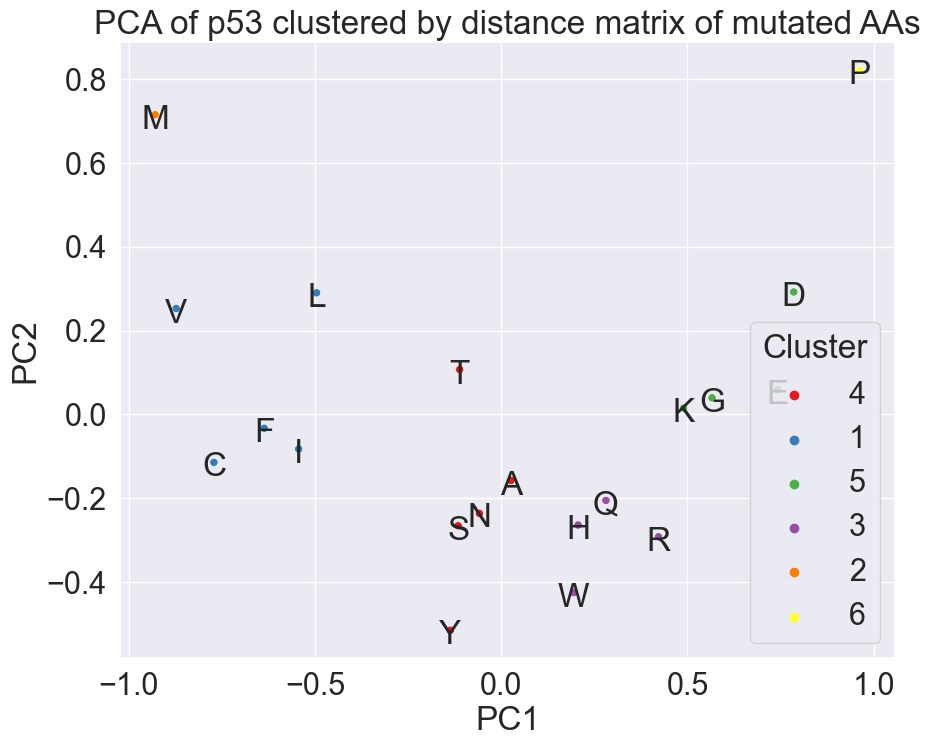

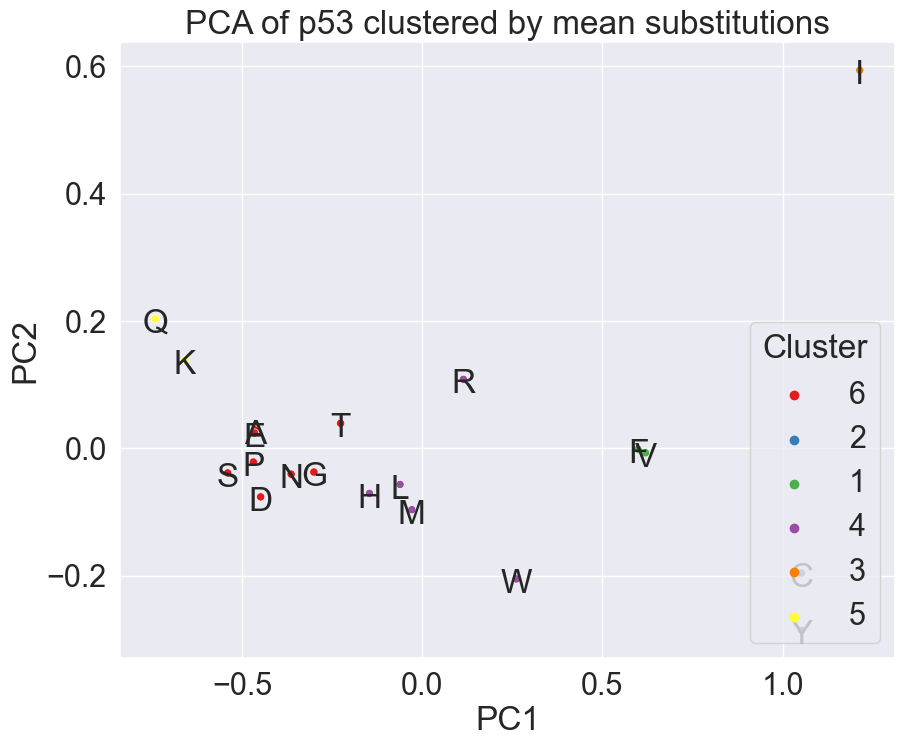

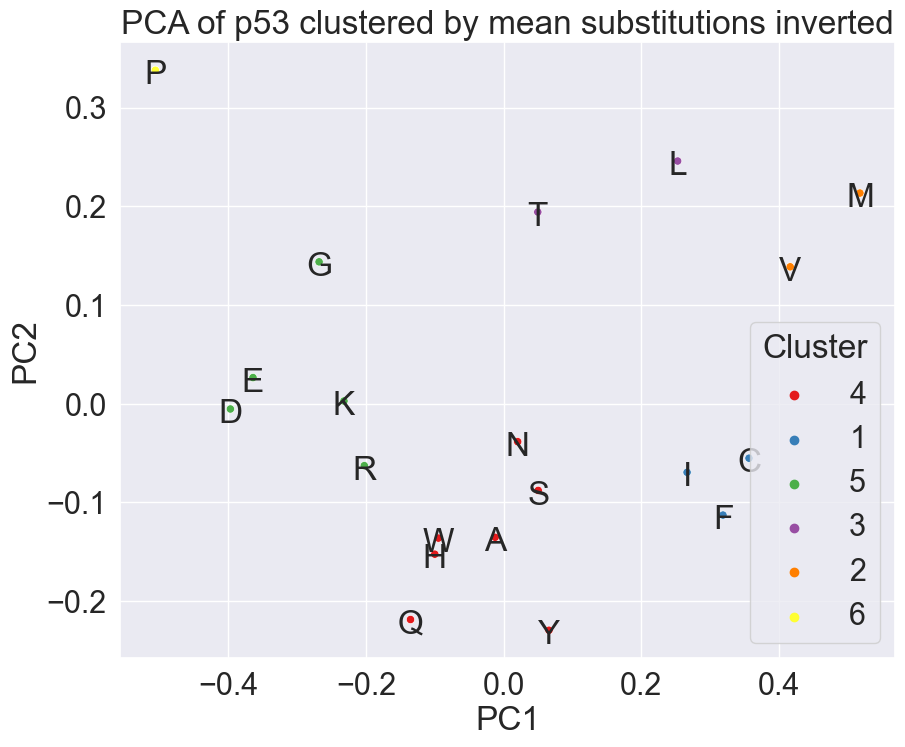

In [12]:
# Plotting, after pca and hierarchical clustering. clusters are defined by the colors shown in the legend.
de.pca_hierarchical_plot(dist_chem, optimal_num_cluster= clusters_by_sil_chem, title = "AAs clustered by chemical properties", show_var=True)

de.pca_hierarchical_plot(dist_wt_p53, optimal_num_cluster=clusters_by_sil_p53, title = "p53 clustered by distance matrix of WT AAs")
de.pca_hierarchical_plot(dist_mut_p53, optimal_num_cluster=clusters_by_sil_p53, title = "p53 clustered by distance matrix of mutated AAs", show_var=True)

de.pca_hierarchical_plot(mean_subs_wt_p53, optimal_num_cluster=clusters_by_sil_p53, title = "p53 clustered by mean substitutions of WT AAs")
de.pca_hierarchical_plot(mean_subs_mut_p53, optimal_num_cluster=clusters_by_sil_p53, title = "p53 clustered by mean substitutions of mutated AAs")

#------------------------------------------------------------------
# I HAVE NO IDEA WHY THESE PLOTS LOOK SO AWFUL IN THIS NOTEBOOK. For better plots look at the de.clustering_pca_plotting.ipynb file

##### *Outlook for Data Exploration*

TO MAKE THESE PLOTS FOR EACH DOMAIN: Take a look at the de.pca_hierarchical_plotting_domains.ipynb file

TO SEE THE PLOTS WITH K-MEANS: To quantify the effects of the clustering method used (here: hierarchical clustering), we also performed clustering with kmeans to compare the results in the report. Take a look at the de.pca_kmeans_plotting.ipynb file

TO PROOF OUR CODE RUNS ON ALL DATASETS: We ran our code on the Stiffler Dataset on E. coli ß-Lactamase. To see the plots, take a look at the pca_hierarchical_plotting_ßlactamase.ipynb file

## Domain comparison
#### Comparing Clusterings of substitutions in the context of specific protein domains

For the comparison of the domains we first cut our data into smaller corresponding chunks. We then applied different types of analyses on those domains, all of which can be seen in the domain_comparison folder. We then repeated those steps with only the aminoacids reachable with a single base mutation (SMU) and with amino acids belonging to random codons. We then compared the complete dataset to the SMU dataset domain-wise. Also, the random mutations where compared to the SMU.

In [ ]:
# All DMS scores divided onto the different domains
all_dms = plt.imread('../domain_comparison/data/all_dms.png')

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(all_dms)
plt.axis('off')
plt.show()

In [ ]:
#Sinlge mutations only
smu_dms = plt.imread('../domain_comparison/data/smu_dms.png')
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(smu_dms)
plt.axis('off')
plt.show()

In [ ]:
#Comparing DNA binding domain
all_vs_smu = plt.imread('../domain_comparison/data/all_vs_smu.png')
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(all_vs_smu)
plt.axis('off')
plt.show()

## Calculating severity scores
#### Matching DMS_scores with the mutation probability (only for single mutations)


In [ ]:
#Test for the aminoacid sequence obtained from the DNA sequence online
amino_acids_string = ses.translate_codons_to_string(ses.p53_codons_gia)

print(amino_acids_string)

# BLASTing shows: DNA sequence encodes the AA sequence which is the one the Kotler dataset uses as a reference! Position 72 is Proline, not Arginine.
#However: We want to use the Giacomelli dataset for this analysis, as the Kotler dataset does not contain mutational data for the whole sequence of p53. Therefore, we need to personally edit

In [ ]:
#editing AA 72 from Proline to Arginine by hand: no information available which DNA sequence was used by Giacomelli. Couldn't find information in paper...

#change P codon to R
p53_codons_kotler = [ses.rna_sequence[i:i+3] for i in range(0, len(ses.rna_sequence), 3)]
p53_codons_gia = p53_codons_kotler
p53_codons_gia[71] = "CGC"

#generate all AA reachable by single mutation for the whole length of p53
p53_var_frame_raw: pd.DataFrame = ses.translate_codons_df(ses.generate_codon_variations(ses.p53_codons_gia))

#cleaning single mutations of STOP codons
p53_var_frame = ses.clean_variation_matrix(p53_var_frame_raw)

In [ ]:
#prepare p53 dataset: might need transposing the df
df = dc.df_transform(norm_frame).T

#select all single mutations from DMS and calculate severity score
sel_mut: pd.DataFrame = ses.select_smut(df, p53_var_frame)
severity_score_p53: pd.DataFrame = ses.prob_smut(sel_mut,p53_var_frame)

sns.heatmap(dc.min_max_norm(severity_score_p53))
#hier sieht es so aus, als ob Arginin grundsätzlich die Fitness des Proteins negativ beeinflusst. Könnte man vllt untersuchen, ob das tatsächlich so ist und wie signifikant diese Feststellung ist.

In [ ]:
# next -> which probable variations did show an increased fitness score? Is there an AMS with increased DMS score, that
# is not probable by single base Mutation?

#doing analysis on other dataframes

In [ ]:
severity_score_p53.compare(dms_scores, keep_equal=True, keep_shape=True, result_names=('smut', 'dms'))